# Krakow Transport Network Analysis
## Combining GTFS and OSM Data to Identify Critical Infrastructure

---

### Overview
This notebook analyzes Krakow's transport network by combining:
- **GTFS data**: Public transport schedules and routes
- **OSM data**: Street network infrastructure

We'll identify critical nodes using graph centrality metrics and visualize the integrated network.

In [ ]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import Point, LineString
from scipy.spatial import cKDTree
from matplotlib.colors import TwoSlopeNorm
import plotly.graph_objects as go
import zipfile


# Configure OSMnx
ox.settings.log_console = True
ox.settings.use_cache = True
ox.settings.timeout = 600

# Check if the GTFS data directory exists, if not, extract from zip
if not os.path.exists('gtfs'):
    if os.path.exists('gtfs.zip'):
        with zipfile.ZipFile('gtfs.zip', 'r') as zip_ref:
            zip_ref.extractall('gtfs')
        print("Extracted gtfs.zip to gtfs/")
    else:
        print("gtfs.zip not found. Please provide the GTFS data.")

# Set the directory for saving analysis results
RESULTS_DIR = 'results'
GTFS_KRK_A = "gtfs/GTFS_KRK_A"

GTFS_DIR = os.path.join(RESULTS_DIR, 'gtfs_graph')
OSM_DIR = os.path.join(RESULTS_DIR, 'osm_graph')
MERGED_DIR = os.path.join(RESULTS_DIR, 'merged_gtfs_osm')

# Create directories if they do not exist
if not os.path.exists(GTFS_DIR):
    os.makedirs(GTFS_DIR)
if not os.path.exists(OSM_DIR):
    os.makedirs(OSM_DIR)
if not os.path.exists(MERGED_DIR):
    os.makedirs(MERGED_DIR)

Extracted gtfs.zip to gtfs/


## 1. Load and Prepare GTFS Data

In [37]:
def load_gtfs(data_dir=GTFS_KRK_A):
    """Load and preprocess GTFS datasets"""
    files = {
        'shapes': 'shapes.txt',
        'stops': 'stops.txt',
        'trips': 'trips.txt',
        'routes': 'routes.txt',
        'stop_times': 'stop_times.txt',
        'calendar': 'calendar.txt',
        'calendar_dates': 'calendar_dates.txt'
    }
    
    dfs = {}
    for name, file in files.items():
        try:
            dfs[name] = pd.read_csv(f'{data_dir}/{file}')
            print(f"Loaded {file}: {dfs[name].shape[0]} rows")
        except FileNotFoundError:
            print(f"Warning: {file} not found")
    return dfs

# Load data
gtfs = load_gtfs()

Loaded shapes.txt: 834851 rows
Loaded stops.txt: 3010 rows
Loaded trips.txt: 40368 rows
Loaded routes.txt: 167 rows
Loaded stop_times.txt: 882311 rows
Loaded calendar.txt: 5 rows
Loaded calendar_dates.txt: 8 rows


## 2. Analyze Transit Operations

In [3]:
def analyze_transit_operations(trips_df):
    """Analyze number of trips per route and direction"""
    # Count trips per route and direction
    counts = trips_df.groupby(['route_id', 'direction_id'])['trip_id'].count().reset_index()
    counts['route_direction'] = counts['route_id'].astype(str) + ' - ' + counts['direction_id'].astype(str)
    
    # Create interactive bar chart
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=counts['trip_id'], 
        y=counts['route_direction'], 
        orientation='h', 
        text=counts['trip_id'],
        textposition='outside'
    ))
    
    fig.update_layout(
        title='Number of Trips per Route and Direction',
        xaxis_title='Number of Trips',
        yaxis_title='Route - Direction',
        yaxis={'categoryorder': 'total ascending'},
        height=800
    )
    
    fig.show()
    return counts

# Analyze transit operations
trip_counts = analyze_transit_operations(gtfs['trips'])

## 3. Preprocess Route Shapes

In [4]:
def preprocess_shapes(shapes_df):
    """Convert shape points into segments"""
    # Create segments between consecutive shape points
    coords = shapes_df[["shape_pt_lat", "shape_pt_lon", "shape_pt_sequence"]]
    coords_roll_1 = np.roll(coords, 1, axis=0)
    
    segments = pd.DataFrame(
        np.concatenate([coords_roll_1, coords], axis=1),
        columns=["start_lat", "start_lng", "start_seq", "end_lat", "end_lng", "end_seq"]
    )
    
    segments_df = shapes_df[["shape_id"]].join(segments)
    segments_df = segments_df[segments_df.end_seq != 1]  # Remove artificial segments
    segments_df = segments_df.drop(columns=['end_seq']).rename(columns={"start_seq": "seq"})
    
    return segments_df

# Preprocess shapes
segments_df = preprocess_shapes(gtfs['shapes'])

## 4. Calculate Segment Utilization

- **shape_per_day**: Counts the number of trips per shape (route pattern).
- **segment_per_day**: Merges this count onto every segment belonging to that shape, so every segment in a shape gets the total trip count for that shape.
- **segment_day_trips**: Groups by segment coordinates and sums the trip counts.

If a segment appears in multiple shapes, its trip counts are summed across all shapes it appears in.


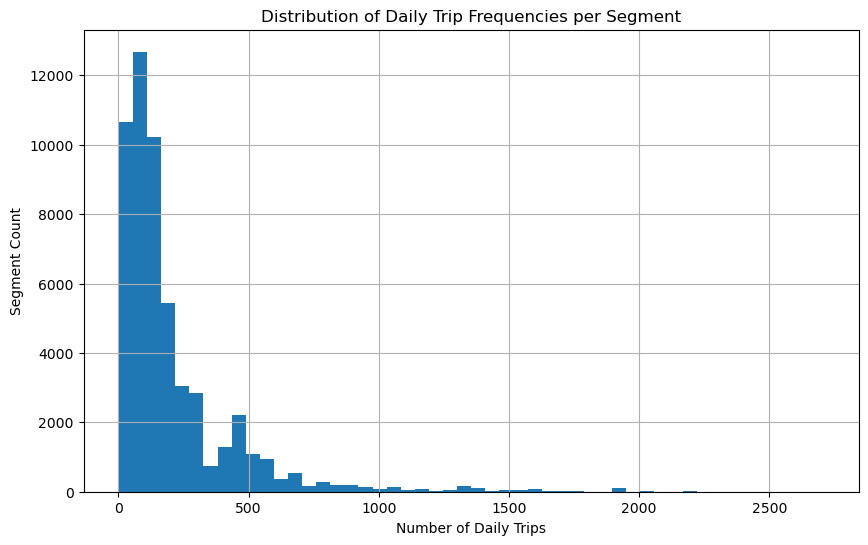

In [39]:
def calculate_segment_utilization(trips_df, segments_df):
    """Calculate daily trip frequency per segment"""
    # Count trips per shape
    shape_per_day = trips_df[trips_df['direction_id'] == 1].groupby(['shape_id'])['trip_id'].count().reset_index()
    
    # Merge with segments
    segment_per_day = pd.merge(segments_df, shape_per_day, on="shape_id")
    
    # Aggregate by segment
    segment_day_trips = segment_per_day.groupby(
        by=["start_lat", "start_lng", "end_lat", "end_lng"]
    ).sum("trip_id").reset_index()
    
    # Create histogram of trip frequencies
    plt.figure(figsize=(10, 6))
    segment_day_trips['trip_id'].hist(bins=50)
    plt.title('Distribution of Daily Trip Frequencies per Segment')
    plt.xlabel('Number of Daily Trips')
    plt.ylabel('Segment Count')
    plt.savefig(os.path.join(GTFS_DIR, 'segment_trip_distribution.png'))
    plt.show()
    return segment_day_trips

# Calculate segment utilization
segment_day_trips = calculate_segment_utilization(gtfs['trips'], segments_df)

In [6]:
print(segment_day_trips.head())
print(segment_day_trips.describe())
print("Total segments:", len(segment_day_trips))
print(segment_day_trips.sort_values('trip_id', ascending=False).head(10))

   start_lat  start_lng    end_lat    end_lng    seq  trip_id
0  49.899553  19.835309  49.899561  19.835358  221.0       80
1  49.899556  19.835255  49.899553  19.835309  220.0       80
2  49.899561  19.835358  49.899577  19.835402  222.0       80
3  49.899570  19.835204  49.899556  19.835255  219.0       80
4  49.899577  19.835402  49.899600  19.835436  223.0       80
          start_lat     start_lng       end_lat       end_lng           seq  \
count  54195.000000  54195.000000  54195.000000  54195.000000  54195.000000   
mean      50.053147     19.923208     50.053138     19.923241   1024.806071   
std        0.065668      0.122874      0.065630      0.122811   1575.463696   
min       49.899553     19.583692     49.899553     19.583692      1.000000   
25%       50.004684     19.835824     50.004696     19.835834    213.000000   
50%       50.055972     19.931807     50.055921     19.931813    514.000000   
75%       50.096551     19.999575     50.096540     19.999558   1178.000000

In [7]:
# Show segments with more than 100 trips per day
busy_segments = segment_day_trips[segment_day_trips['trip_id'] > 1500]
print("Segments with more than 100 trips per day:")
print(busy_segments.sort_values('trip_id', ascending=False))

# Optionally, save to CSV for further analysis
busy_segments.to_csv('busy_segments_over_100.csv', index=False)

Segments with more than 100 trips per day:
       start_lat  start_lng    end_lat    end_lng     seq  trip_id
21673  50.031936  19.948258  50.031936  19.948258  6069.0     2708
27840  50.059359  19.925291  50.059444  19.925240  7155.0     2218
28473  50.061682  19.923997  50.062129  19.923779  7309.0     2218
27895  50.059444  19.925240  50.059466  19.925227  7169.0     2218
27916  50.059466  19.925227  50.059522  19.925193  7183.0     2218
...          ...        ...        ...        ...     ...      ...
27098  50.055976  19.926876  50.055745  19.927018  2247.0     1559
27111  50.056069  19.926830  50.055976  19.926876  2240.0     1559
27112  50.056069  19.926830  50.056069  19.926830  2233.0     1559
27004  50.055217  19.927429  50.055196  19.927472  2275.0     1559
23510  50.039462  19.937322  50.039593  19.937219  3910.0     1544

[355 rows x 6 columns]


### 4.1 Let's identify the busiest segment and the trips that use it

In [8]:
# Find the segment with the highest trip count
busiest_segment = segment_day_trips.sort_values('trip_id', ascending=False).iloc[0]
print(busiest_segment)

start_lat      50.031936
start_lng      19.948258
end_lat        50.031936
end_lng        19.948258
seq          6069.000000
trip_id      2708.000000
Name: 21673, dtype: float64


In [9]:
# Find all rows in segments_df that match the busiest segment's coordinates
mask = (
    (segments_df['start_lat'] == busiest_segment['start_lat']) &
    (segments_df['start_lng'] == busiest_segment['start_lng']) &
    (segments_df['end_lat'] == busiest_segment['end_lat']) &
    (segments_df['end_lng'] == busiest_segment['end_lng'])
)
matching_segments = segments_df[mask]
print(matching_segments)

# Get all shape_ids for this segment
shape_ids = matching_segments['shape_id'].unique()

# Find all trips that use these shapes
trips_using_segment = gtfs['trips'][gtfs['trips']['shape_id'].isin(shape_ids)]
print(trips_using_segment[['trip_id', 'route_id', 'direction_id', 'shape_id']])

          shape_id  start_lat  start_lng    seq    end_lat    end_lng
468978  shape_4027  50.031936  19.948258  735.0  50.031936  19.948258
468979  shape_4027  50.031936  19.948258  736.0  50.031936  19.948258
471462  shape_4031  50.031936  19.948258  367.0  50.031936  19.948258
471463  shape_4031  50.031936  19.948258  368.0  50.031936  19.948258
475324  shape_7529  50.031936  19.948258  367.0  50.031936  19.948258
475325  shape_7529  50.031936  19.948258  368.0  50.031936  19.948258
477479  shape_7534  50.031936  19.948258  735.0  50.031936  19.948258
477480  shape_7534  50.031936  19.948258  736.0  50.031936  19.948258
506055  shape_4150  50.031936  19.948258  843.0  50.031936  19.948258
506056  shape_4150  50.031936  19.948258  844.0  50.031936  19.948258
508182  shape_4388  50.031936  19.948258  152.0  50.031936  19.948258
508183  shape_4388  50.031936  19.948258  153.0  50.031936  19.948258
510770  shape_7582  50.031936  19.948258  152.0  50.031936  19.948258
510771  shape_7582  

In [33]:
# Get the 20 busiest segments
top_n = 20
top_segments = segment_day_trips.sort_values('trip_id', ascending=False).head(top_n)

# Center the map on the first segment
center_lat = top_segments.iloc[0]['start_lat']
center_lng = top_segments.iloc[0]['start_lng']
m = folium.Map(location=[center_lat, center_lng], zoom_start=13)

# Add each segment as a line
for _, row in top_segments.iterrows():
    folium.PolyLine(
        locations=[
            [row['start_lat'], row['start_lng']],
            [row['end_lat'], row['end_lng']]
        ],
        color='red',
        weight=6,
        popup=f"Trips per day: {row['trip_id']}"
    ).add_to(m)

m.save(os.path.join(GTFS_DIR, 'busiest_segments_top20.html'))

## 5. Build Stop Network Graph

Let's prepare the visualization function for the graph

In [ ]:
def visualize_stop_network(G, stops_df, filename='gtfs_network_graph.html', max_edges=1000):
    """Visualize the stop network (nodes and edges) as an interactive Folium map."""

    # Get node positions
    stop_positions = stops_df.set_index('stop_id')[['stop_lat', 'stop_lon']].to_dict('index')
    center_lat = stops_df['stop_lat'].mean()
    center_lon = stops_df['stop_lon'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')

    # Draw edges (limit for performance)
    for i, (u, v, data) in enumerate(G.edges(data=True)):
        if i > max_edges:
            break
        if u in stop_positions and v in stop_positions:
            folium.PolyLine(
                locations=[
                    [stop_positions[u]['stop_lat'], stop_positions[u]['stop_lon']],
                    [stop_positions[v]['stop_lat'], stop_positions[v]['stop_lon']]
                ],
                color='red', weight=2, opacity=0.5
            ).add_to(m)

    # Draw nodes
    for stop_id, pos in stop_positions.items():
        folium.CircleMarker(
            location=[pos['stop_lat'], pos['stop_lon']],
            radius=3, color='black', fill=True, fill_opacity=0.7
        ).add_to(m)

    full_path = os.path.join(GTFS_DIR, filename)
    m.save(full_path)
    print(f"Stop network map saved as {full_path}")

In [43]:
def build_stop_network(stop_times_df, trips_df, stops_df):
    """Create directed graph of stops"""
    # Merge stop_times with trips to get direction information
    stop_times_with_direction = pd.merge(
        stop_times_df, 
        trips_df[['trip_id', 'direction_id']], 
        on='trip_id'
    )
    
    # Filter for direction_id = 1 and sort stops
    direction_1_stop_times = stop_times_with_direction[
        stop_times_with_direction['direction_id'] == 1
    ].sort_values(['trip_id', 'stop_sequence'])
    
    # Create edges between consecutive stops
    direction_1_stop_times['to_stop'] = direction_1_stop_times.groupby('trip_id')['stop_id'].shift(-1)
    edges_df = direction_1_stop_times.dropna(subset=['to_stop'])[['stop_id', 'to_stop']]
    edges_df.columns = ['from_stop', 'to_stop']
    
    # Calculate edge weights
    edge_weights = edges_df.groupby(['from_stop', 'to_stop']).size().reset_index(name='weight')
    
    # Create directed graph
    G = nx.DiGraph()
    for _, row in edge_weights.iterrows():
        G.add_edge(row['from_stop'], row['to_stop'], weight=row['weight'])
    visualize_stop_network(G, gtfs['stops'])
    # Calculate centrality measures
    print("Calculating eigenvector centrality...")
    eigen_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    
    print("Calculating PageRank...")
    pagerank = nx.pagerank(G, weight='weight')
    
    print("Calculating betweenness centrality...")
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    
    print("Calculating degree centrality...")
    degree_centrality = nx.degree_centrality(G)
    
    # Create DataFrames
    centrality_dfs = {}
    for name, centrality in [('eigen', eigen_centrality), 
                            ('pagerank', pagerank),
                            ('betweenness', betweenness_centrality),
                            ('degree', degree_centrality)]:
        df = pd.DataFrame.from_dict(centrality, orient='index', columns=[name]).reset_index()
        df.columns = ['stop_id', name]
        df = pd.merge(df, stops_df[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']], on='stop_id')
        centrality_dfs[name] = df
    
    return centrality_dfs

# Build stop network
centrality_dfs = build_stop_network(gtfs['stop_times'], gtfs['trips'], gtfs['stops'])

Stop network map saved as results/gtfs_graph/gtfs_network_graph.html
Calculating eigenvector centrality...
Calculating PageRank...
Calculating betweenness centrality...
Calculating degree centrality...


In [13]:

# Display top central stops
print("Top Eigenvector Centrality Stops:")
print(centrality_dfs['eigen'].sort_values('eigen', ascending=False).head(5))

print("\nTop PageRank Stops:")
print(centrality_dfs['pagerank'].sort_values('pagerank', ascending=False).head(5))

print("\nTop Betweenness Centrality Stops:")
print(centrality_dfs['betweenness'].sort_values('betweenness', ascending=False).head(5))

print("\nTop Degree Centrality Stops:")
print(centrality_dfs['degree'].sort_values('degree', ascending=False).head(5))

Top Eigenvector Centrality Stops:
               stop_id     eigen              stop_name   stop_lat   stop_lon
203   stop_1089_260807  0.489462  Dworzec Główny Zachód  50.067783  19.945273
41        stop_51_7306  0.450395           Politechnika  50.071279  19.944103
619       stop_50_7103  0.274897           Nowy Kleparz  50.073617  19.937271
1646  stop_1089_260809  0.247543  Dworzec Główny Zachód  50.067204  19.944498
706       stop_55_7903  0.189571         Plac Inwalidów  50.069381  19.926953

Top PageRank Stops:
               stop_id  pagerank            stop_name   stop_lat   stop_lon
8     stop_1654_314104  0.002773      Muzeum Narodowe  50.058644  19.925202
769     stop_532_74902  0.002575       Góra Borkowska  50.007410  19.925282
1457    stop_530_74704  0.002422        Borek Fałęcki  50.011291  19.926720
375        stop_7_1203  0.002408  Rondo Ofiar Katynia  50.086632  19.891059
1677    stop_540_75802  0.002225               Judyma  50.002402  19.922612

Top Betweenness Cent

## 6. Visualize Central Stops

In [44]:
def visualize_central_stops(centrality_df, centrality_type, title):
    """Create interactive map of stops with centrality"""
    # Normalize centrality for visualization
    centrality_df['normalized'] = centrality_df[centrality_type] / centrality_df[centrality_type].max()
    
    # Create map with a lighter background
    center_lat = centrality_df['stop_lat'].mean()
    center_lon = centrality_df['stop_lon'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')
    
    # Add stops
    for idx, row in centrality_df.iterrows():
        radius = 5 + (row['normalized'] * 30)
        color = f'#{int(255 * row["normalized"]):02x}0000'
        
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=radius,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=f"{row['stop_name']}<br>{centrality_type}: {row[centrality_type]:.4f}"
        ).add_to(m)
    
    # Add title
    title_html = f'''
        <h3 align="center" style="font-size:16px"><b>{title}</b></h3>
        '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    return m

# Visualize different centrality measures
eigen_map = visualize_central_stops(
    centrality_dfs['eigen'], 
    'eigen', 
    'Eigenvector Centrality - Influence in Well-connected Clusters'
)

eigen_map.save(os.path.join(GTFS_DIR,'eigen_centrality.html'))

pagerank_map = visualize_central_stops(
    centrality_dfs['pagerank'], 
    'pagerank', 
    'PageRank - High-traffic Transit Points'
)
pagerank_map.save(os.path.join(GTFS_DIR,'pagerank.html'))


betweenness_map = visualize_central_stops(
    centrality_dfs['betweenness'], 
    'betweenness', 
    'Betweenness Centrality - Key Transfer Points'
)
betweenness_map.save(os.path.join(GTFS_DIR,'betweenness_centrality.html'))

degree_map = visualize_central_stops(
    centrality_dfs['degree'], 
    'degree', 
    'Degree Centrality - Most Connected Stops'
)
degree_map.save(os.path.join(GTFS_DIR,'degree_centrality.html'))

## 7. Integrate OSM Street Data

In [15]:
def integrate_osm_data(place="Kraków, Poland"):
    """Download and prepare OSM street data"""
    print(f"Downloading OSM data for {place}...")
    # Get the street network
    G = ox.graph_from_place(place, network_type='drive', simplify=True)
    
    # Convert to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(G)
    
    print(f"OSM data downloaded: {len(nodes)} nodes, {len(edges)} edges")
    return G, nodes, edges

# Integrate OSM data
krk_streets, osm_nodes, osm_edges = integrate_osm_data()

OSM data downloaded: 9620 nodes, 21168 edges


In [ ]:
def visualize_osm_streets(osm_nodes, osm_edges, filename='krakow_osm_streets.html'):
    """Visualize OSM street network as an interactive Folium map."""
    import folium

    center_lat = osm_nodes['y'].mean()
    center_lon = osm_nodes['x'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    for _, row in osm_edges.iterrows():
        if row['geometry'].geom_type == 'LineString':
            folium.PolyLine(
                locations=[(lat, lon) for lon, lat in row['geometry'].coords],
                color='blue', weight=2, opacity=0.5
            ).add_to(m)
        elif row['geometry'].geom_type == 'MultiLineString':
            for linestring in row['geometry']:
                folium.PolyLine(
                    locations=[(lat, lon) for lon, lat in linestring.coords],
                    color='blue', weight=2, opacity=0.5
                ).add_to(m)
    m.save(filename)
    print(f"Interactive map saved as {filename}")

visualize_osm_streets(osm_nodes, osm_edges)


## 8. Create Multimodal Network

In [22]:
def create_multimodal_network(krk_streets, segment_day_trips, merge_close_nodes=False, distance_threshold=0.0002):
    """Combine OSM street network with GTFS bus segments, with optional merging of close nodes"""
    integrated = nx.DiGraph()
    
    # Add OSM nodes
    for node, data in krk_streets.nodes(data=True):
        integrated.add_node(f'[ROAD]{node}', **data)
    
    # Add OSM edges
    for u, v, data in krk_streets.edges(data=True):
        if 'geometry' in data:
            geometry = data['geometry']
        else:
            start = Point(krk_streets.nodes[u]['x'], krk_streets.nodes[u]['y'])
            end = Point(krk_streets.nodes[v]['x'], krk_streets.nodes[v]['y'])
            geometry = LineString([start, end])
        highway = data.get('highway', 'unknown')
        if isinstance(highway, list):
            highway = highway[0]
        integrated.add_edge(
            f'[ROAD]{u}', 
            f'[ROAD]{v}', 
            road_size=highway, 
            geometry=geometry, 
            length=data.get('length', 0),
            type='road'
        )
    
    # Add GTFS bus segments
    for _, row in segment_day_trips.iterrows():
        start_node = f'[BUS]{row.start_lng},{row.start_lat}'
        end_node = f'[BUS]{row.end_lng},{row.end_lat}'
        start = Point(row.start_lng, row.start_lat)
        end = Point(row.end_lng, row.end_lat)
        geometry = LineString([start, end])
        integrated.add_node(start_node, x=row.start_lng, y=row.start_lat)
        integrated.add_node(end_node, x=row.end_lng, y=row.end_lat)
        integrated.add_edge(
            start_node, 
            end_node, 
            road_size='bus', 
            geometry=geometry, 
            type='bus', 
            arrivals=row['trip_id']
        )
    
    print(f"Integrated network created: {integrated.number_of_nodes()} nodes, {integrated.number_of_edges()} edges")
    
    if merge_close_nodes:
        # Merge nodes that are spatially close
        # Extract coordinates and node names
        node_coords = []
        node_names = []
        for node, data in integrated.nodes(data=True):
            if 'x' in data and 'y' in data:
                node_coords.append([data['x'], data['y']])
                node_names.append(node)
        coords = np.array(node_coords)
        tree = cKDTree(coords)
        pairs = tree.query_pairs(distance_threshold)
        
        # Union-Find for merging
        groups = nx.utils.union_find.UnionFind()
        for i, j in pairs:
            groups.union(node_names[i], node_names[j])
        
        # Build merged graph
        merged = nx.DiGraph()
        for node, data in integrated.nodes(data=True):
            rep = groups[node]
            if rep not in merged:
                merged.add_node(rep, **data)
        for u, v, data in integrated.edges(data=True):
            rep_u = groups[u]
            rep_v = groups[v]
            merged.add_edge(rep_u, rep_v, **data)
        print(f"Merged network: {merged.number_of_nodes()} nodes, {merged.number_of_edges()} edges")
        return merged

    return integrated

# Example usage:
integrated_network = create_multimodal_network(krk_streets, segment_day_trips, merge_close_nodes=True, distance_threshold=0.0005)

Integrated network created: 54224 nodes, 75207 edges
Merged network: 8839 nodes, 22308 edges


## 9. Assign Flow Capacities

In [ ]:
def assign_flow_capacities(integrated_network):
    """Assign flow capacities based on road type and bus frequency"""
    # Capacity definitions (vehicles/day)
    capacity = {
        "motorway": 180_000,
        "trunk": 138_000,
        "primary": 53_000,
        "secondary": 23_000,
        "tertiary": 5_300,
        "unclassified": 12_300,
        "residential": 4_000,
        "service": 750,
        "living_street": 1000,
        
        "motorway_link": 36_000,
        "trunk_link": 27_600,
        "primary_link": 10_600,
        "secondary_link": 4_600,
        "tertiary_link": 1_060,
        "bus": None  # Special handling
    }
    
    # Assign capacities
    for u, v, data in integrated_network.edges(data=True):
        if data['type'] == 'bus':
            # Bus capacity = trips × assumed capacity per bus
            data['flow_capacity'] = data.get('arrivals', 0) * 50
        elif data['type'] == 'road' and data['road_size'] in capacity:
            data['flow_capacity'] = capacity[data['road_size']]
        else:
            data['flow_capacity'] = 1_000  # Default capacity
    
    print("Flow capacities assigned to all edges")
    return integrated_network

# Assign capacities
integrated_network = assign_flow_capacities(integrated_network)

Flow capacities assigned to all edges


## 10. Analyze Multimodal Centrality

We want to analyze the whole urban mobility system (cars + buses):

We are using the multimodal (integrated) network (integrated_network), where nodes are both road intersections and bus segment endpoints, and edges are both roads and bus routes.
This is essential for understanding how public transport and road infrastructure interact, and for identifying critical points in the entire transport system.

In [20]:
def analyze_multimodal_centrality(integrated_network):
    """Calculate centrality metrics on the multimodal network"""
    print("Calculating eigenvector centrality for multimodal network...")
    eigen_centrality = nx.eigenvector_centrality(integrated_network, weight='flow_capacity', max_iter=1000)
    
    print("Calculating PageRank for multimodal network...")
    pagerank = nx.pagerank(integrated_network, weight='flow_capacity')
    
    print("Calculating betweenness centrality for multimodal network...")
    betweenness_centrality = nx.betweenness_centrality(integrated_network, weight='flow_capacity')

    print("Calculating degree centrality for multimodal network...")
    degree_centrality = nx.degree_centrality(integrated_network)
    
    # Prepare results
    centrality_measures = {
        'eigen': eigen_centrality,
        'pagerank': pagerank,
        'betweenness': betweenness_centrality,
        'degree': degree_centrality
    }
    
    # Create DataFrames
    centrality_dfs = {}
    for name, measure in centrality_measures.items():
        df = pd.DataFrame.from_dict(measure, orient='index', columns=[name])
        centrality_dfs[name] = df
    
    return centrality_dfs

# Analyze multimodal centrality
multimodal_centrality = analyze_multimodal_centrality(integrated_network)

NameError: name 'integrated_network' is not defined

In [ ]:
import pickle

# Save graph
with open('integrated_network.pkl', 'wb') as f:
    pickle.dump(integrated_network, f)

# Load graph
with open('integrated_network.pkl', 'rb') as f:
    integrated_network = pickle.load(f)

## 11. Visualize Multimodal Network

In [ ]:
def visualize_multimodal_network(integrated_network, centrality_type='eigen'):
    """Create interactive visualization of multimodal network"""
    # Create base map
    center_lat = 50.0614
    center_lon = 19.9372
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Color scheme for road types
    road_colors = {
        'motorway': '#FF0000',
        'trunk': '#FF4500',
        'primary': '#FFA500',
        'secondary': '#FFD700',
        'tertiary': '#FFFF00',
        'unclassified': '#ADFF2F',
        'residential': '#7CFC00',
        'service': '#98FB98',
        'living_street': '#90EE90',
        'bus': '#0000FF',
        'unknown': '#A9A9A9'
    }
    
    # Get centrality values
    centrality = multimodal_centrality[centrality_type]
    min_centrality = centrality.min()[0]
    max_centrality = centrality.max()[0]
    
    # Function to normalize centrality
    def normalize_centrality(val):
        return (val - min_centrality) / (max_centrality - min_centrality)
    
    # Add edges to map
    for u, v, data in integrated_network.edges(data=True):
        # Get coordinates
        u_node = integrated_network.nodes[u]
        v_node = integrated_network.nodes[v]
        
        # Determine color
        if data['type'] == 'road':
            road_type = data.get('road_size', 'unknown')
            color = road_colors.get(road_type, road_colors['unknown'])
        else:
            color = road_colors['bus']
        
        # Get centrality (average of start and end nodes)
        u_centrality = centrality.loc[u][0] if u in centrality.index else min_centrality
        v_centrality = centrality.loc[v][0] if v in centrality.index else min_centrality
        avg_centrality = (u_centrality + v_centrality) / 2
        
        # Set weight based on centrality
        weight = 1 + 5 * normalize_centrality(avg_centrality)
        
        # Create polyline
        folium.PolyLine(
            locations=[[u_node['y'], u_node['x']], [v_node['y'], v_node['x']]],
            color=color,
            weight=weight,
            opacity=0.7,
            popup=f"Type: {data.get('road_size', 'bus')}<br>Capacity: {data.get('flow_capacity', 'N/A')}"
        ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: 380px; 
         border:2px solid grey; z-index:9999; font-size:14px;
         background-color:white; padding:10px;">
         <b>Network Legend</b><br>
         <div style="margin-top:10px;"><b>Road Types:</b></div>
    '''
    
    for road_type, color in road_colors.items():
        legend_html += f'<i style="background:{color}; width:20px; height:20px; display:inline-block;"></i> {road_type}<br>'
    
    legend_html += '''
    <div style="margin-top:20px;"><b>Line Thickness:</b><br>
        <span style="border-bottom: 1px solid black; width: 20px; display: inline-block;">&nbsp;</span> Low centrality<br>
        <span style="border-bottom: 6px solid black; width: 20px; display: inline-block;">&nbsp;</span> High centrality
    </div>
    </div>
    '''
    
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add title
    title_html = f'''
        <h3 align="center" style="font-size:16px"><b>Krakow Multimodal Network - {centrality_type.capitalize()} Centrality</b></h3>
        '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    return m

# Visualize multimodal network
multimodal_map = visualize_multimodal_network(integrated_network, 'eigen')
multimodal_map.save('multimodal_network.html')

## 12. Critical Node Analysis

In [ ]:
def analyze_critical_nodes(multimodal_centrality, integrated_network):
    """Identify and analyze critical nodes in the multimodal network"""
    # Combine centrality measures
    centrality_df = multimodal_centrality['eigen'].rename(columns={'eigen': 'eigenvector'})
    centrality_df = centrality_df.join(multimodal_centrality['pagerank'])
    centrality_df = centrality_df.join(multimodal_centrality['betweenness'])
    centrality_df = centrality_df.join(multimodal_centrality['degree'])
    
    # Normalize centrality scores
    for col in centrality_df.columns:
        centrality_df[f'{col}_norm'] = (
            centrality_df[col] - centrality_df[col].min()
        ) / (centrality_df[col].max() - centrality_df[col].min())
    
    # Create composite score
    centrality_df['composite_score'] = centrality_df[[f'{col}_norm' for col in centrality_df.columns[:4]]].mean(axis=1)
    
    # Get top 10 critical nodes
    critical_nodes = centrality_df.sort_values('composite_score', ascending=False).head(10)
    
    # Visualize
    plt.figure(figsize=(12, 8))
    critical_nodes[['eigenvector', 'pagerank', 'betweenness', 'degree']].plot(kind='bar')
    plt.title('Top 10 Critical Nodes by Centrality Measures')
    plt.ylabel('Centrality Score')
    plt.xlabel('Node ID')
    plt.xticks(rotation=45)
    plt.legend(title='Centrality Type')
    plt.tight_layout()
    plt.show()
    
    # Analyze node types
    node_types = []
    for node in critical_nodes.index:
        if '[ROAD]' in node:
            node_types.append('Road Intersection')
        elif '[BUS]' in node:
            node_types.append('Bus Stop')
        else:
            node_types.append('Unknown')
    
    critical_nodes['type'] = node_types
    
    # Print insights
    print("\nCritical Node Types:")
    print(critical_nodes['type'].value_counts())
    
    print("\nTop Critical Nodes:")
    print(critical_nodes.head())
    
    return critical_nodes

# Analyze critical nodes
critical_nodes = analyze_critical_nodes(multimodal_centrality, integrated_network)

## 13. Policy Recommendations

In [ ]:
def generate_policy_recommendations(critical_nodes):
    """Generate policy recommendations based on critical nodes"""
    print("Policy Recommendations Based on Critical Node Analysis:")
    
    # Recommendation framework
    recommendations = {
        "Road Intersection": [
            "Implement intelligent traffic light sequencing",
            "Add dedicated turning lanes",
            "Consider grade separation solutions",
            "Improve pedestrian crossing infrastructure"
        ],
        "Bus Stop": [
            "Expand platform capacity",
            "Implement real-time arrival information",
            "Improve pedestrian access routes",
            "Add weather protection features",
            "Create dedicated bus lanes approaching the stop"
        ]
    }
    
    # Generate recommendations for top nodes
    for i, (node, data) in enumerate(critical_nodes.head(3).iterrows(), 1):
        node_type = data['type']
        
        print(f"\nRecommendations for Node #{i} ({node_type}):")
        print(f"- Composite Criticality Score: {data['composite_score']:.3f}")
        
        for rec in recommendations[node_type]:
            print(f"- {rec}")
    
    # System-wide recommendations
    print("""\nSystem-wide Recommendations:
- Create redundancy for critical corridors
- Develop congestion pricing for high-centrality zones
- Prioritize maintenance on critical infrastructure
- Implement real-time monitoring for critical nodes""")

# Generate recommendations
generate_policy_recommendations(critical_nodes)